In [1]:
__author__ = 'Derek Qi'
# Doing portfolio backtest and generates output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from factor_mining.combine_factors import *
from factor_mining.factor_model_regression import *
from factor_mining.factor_preprocessing import *

from factor_model.stock_ret_est import GenReturn 
from GenPosition import *
from backtest_main import *
from performance_analysis.pa_core import *

from factor_mining.factors.momentum import *

from factor_mining.Mark0 import * # This is alpha file

In [2]:
# def backtest_single_period(univ, factor_exp_mat, ret_series, t, silent=True):
# 	'''
# 	Do a single period backtest on univ[t]
# 	t: datetime object that is one of the element in keys of univ
# 	factor_exp_mat, ret_series: factor exposure and return time series
# 	'''
# 	# Set backtest params
# 	lookback = timedelta(weeks=104)
# 	dend = t
# 	dstart = dend - lookback

# 	# Fit single period factor return
# 	fr, fr_mse = factor_model_fit(factor_exp_mat, ret_series, dstart, dend)

# 	fx = factor_exp_mat[dend]
# 	fx = fx.dropna()
# 	# Filt the available pool
# 	univ_fin = univ[dend]
# 	univ_fin = univ_fin.dropna()
# 	# Throw away penny stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
# 	# Throw away illiquid stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
# 	# Throw away things in MA
# 	univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
# 	fx = pd.merge(fx, univ_fin[['ticker']], how='inner', on='ticker')

# 	if 0:
# 		fx.to_csv('./temp/factor_exposure_' + t.strftime('%Y%m%d') + '.csv', index=False)
# 		fr.to_csv('./temp/factor_return_' + t.strftime('%Y%m%d') + '.csv', index=False)

# 	# Calculate position
# 	stock_list, w_opt = GenPosition(fr, fx, U=0.2)
# 	w_opt = PositionFilter(w_opt) # filt away very small number in portfolio
# 	ptfl_full = pd.DataFrame({"ticker": stock_list, "weight": list(w_opt.T[0])})
# 	ptfl_full = pd.merge(ptfl_full, univ_fin[['ticker', 'log_ret']], how='inner', on='ticker')
# 	ptfl_full.loc[ptfl_full.log_ret < -2.5, 'log_ret'] = 0 # Emergency process for stocks in MA for over 6 months
# 	pnl_sp = np.dot(ptfl_full.weight, ptfl_full.log_ret)

# 	if not silent:
# 		print('Pool size: %d' % univ_fin.shape[0])
# 		print(ptfl_full[ptfl_full['weight'] != 0])
# 		print('Period log pnl: %f' % pnl_sp)
# 	return ptfl_full, pnl_sp, fr


# def backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=True):
# 	'''
# 	Run backtest in batch to portfolio from dstart to dend
# 	'''
# 	datelst = sorted(univ.keys())
# 	tin_lst, ptfl_lst, pnl_lst = [], [], []
# 	factor_names = factor_exp_mat[datelst[0]].columns[2:].tolist() # exclude date and ticker column
# 	fr_df = pd.DataFrame(columns = factor_names)
# 	for ti in range(len(datelst)):
# 		t = datelst[ti]
		
# 		if t < dstart or t > dend:
# 			continue

# 		if not silent:
# 			print(t)

# 		tin_lst.append(t)
# 		ptfl, pnl_sp, fr_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t, silent)
# 		ptfl_lst.append(ptfl)
# 		pnl_lst.append(pnl_sp)
# 		fr_df = fr_df.append(fr_sp, ignore_index=True)

# 	fr_df['date'] = tin_lst
# 	fr_df = fr_df[['date'] + factor_names]
# 	pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
# 	return ptfl_lst[-1], pnl, fr_df


# def backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebalance, silent=True):
# 	'''
# 	Backtest with multi-period rebalancing
# 	'''
# 	datelst = sorted(univ.keys())
# 	tin_lst, ptfl_lst, pnl_lst = [], [], []
# 	factor_names = factor_exp_mat[datelst[0]].columns[2:].tolist() # exclude date and ticker column
# 	fr_df = pd.DataFrame(columns = factor_names)
# 	count = 0
# 	for ti in range(len(datelst)):
# 		t = datelst[ti]
		
# 		if t < dstart or t > dend:
# 			continue
		
# 		if not silent:
# 			print(t)
		
# 		tin_lst.append(t)
		
# 		if count == 0:
# 			# Do rebalance
# 			ptfl, pnl_sp, fr_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t, silent)
# 			ptfl_lst.append(ptfl)
# 			pnl_lst.append(pnl_sp)
# 			fr_df = fr_df.append(fr_sp, ignore_index=True)
# 		else:
# 			# Use prev portfolio
# 			ptfl = ptfl_lst[-1].copy()
# 			ptfl = ptfl[['ticker','weight']]
# 			# Filt the available pool
# 			univ_fin = univ[t]
# 			univ_fin = univ_fin.dropna()
# 			# Throw away penny stocks
# 			univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
# 			# Throw away illiquid stocks
# 			univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
# 			# Throw away things in MA
# 			univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
			
# 			# Force clear what is not in the pool now and re-normalize the weight
# 			ptfl = pd.merge(ptfl, univ_fin[['ticker', 'log_ret']], how='inner', on='ticker')
# 			ptfl.loc[ptfl.log_ret < -2.5, 'log_ret'] = 0 # Emergency process for stocks in MA for over 6 months
# 			pnl_sp = np.dot(ptfl.weight, ptfl.log_ret)
			
# 			ptfl_lst.append(ptfl)
# 			pnl_lst.append(pnl_sp)
# 			fr_df = fr_df.append(fr_sp, ignore_index=True)
			
# 			if not silent:
# 				print('Pool size: %d' % univ_fin.shape[0])
# 				print(ptfl[ptfl['weight'] != 0])
# 				print('Period log pnl: %f' % pnl_sp)	
# 		count -= 1
# 		count %= rebalance
# 	pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
# 	fr_df['date'] = tin_lst
# 	fr_df = fr_df[['date'] + factor_names]
# 	return ptfl, pnl, fr_df

In [3]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v3.csv'
    univ = univ_setup(big_table_dir)
    filt_by_name(univ) # This is fucking slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

Setup R3000 universe
use existing binary file
0.387009 seconds


In [4]:
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std)
print('Done')

Calculate factors
Scale each factor


/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/

Winsorize with +/- 3 std


/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/derek-qi/anaconda3/lib/python3.5/site-packages/numpy/lib/

Done


In [5]:
# const setup
factor_names = [k for k in factors.keys()]
N_f = len(factor_names)
datelst = sorted(factor_exp_mat.keys())
N_T = len(datelst)

# Run backtest
# Calc stock returns
rebal = 1
ret_series = log_return(univ, -rebal)

In [12]:
t = datetime(2015, 7, 24)
ptfl_sp, pnl_sp, fr_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t)

In [14]:
fr_sp

momentum      0.011577
beta         -0.004407
market_cap    0.000198
vol10        -0.008479
dtype: float64

In [24]:
t = datetime(2015, 7, 17)
# fit that particular period
[print(n) for n in factor_names]
np.nanmean(factor_exp_mat[t][factor_names], axis=0)

momentum
beta
market_cap
vol10


array([-0.01598088, -0.01563761, -0.0512028 , -0.04782229])

In [53]:
X = factor_exp_mat[t].copy()
r = ret_series[t].copy()

In [55]:
r.columns
Xr = pd.merge(X, r, on='ticker')
Xr.loc[Xr['log_return'] < -2.5, 'log_return'] = np.nan
Xr = Xr.dropna()
X2 = Xr[factor_names]
r2 = Xr['log_return']
LR = LR.fit(X2, r2)
print(LR.coef_)

[ 0.37685013 -0.06914286  0.00947095 -0.01450882]


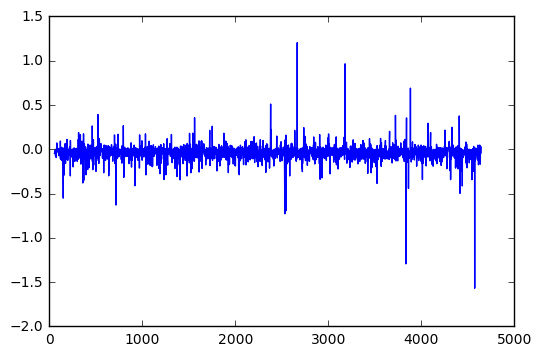

In [63]:
# plt.plot(X2.momentum)
plt.plot(r2)
plt.show()
# ut = univ[t].copy()
# ut[ut.ticker == 'HEAT']

In [6]:
dstart = datetime(2014, 1, 1)
dend = datetime(2016, 12, 31)
print('Start backtest from %s to %s' % (dstart.strftime('%Y/%m/%d'), dend.strftime('%Y/%m/%d')))
ts = time()
# ptfl_fin, pnl, fr_hist = backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=False)
ptfl_fin, pnl, fr_hist = backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebal, silent=False)
te = time()
print(te - ts)

Start backtest from 2014/01/01 to 2016/12/31
2014-01-03 00:00:00
Pool size: 610
        ticker    weight   log_ret
0    X1255459D  0.047052  0.000527
9          ABC  0.103404  0.019820
52         AOS  0.020001 -0.014738
58        ASIA  0.051604  0.000836
70        AZPN  0.012216  0.001682
80         BID  0.038525 -0.023446
86         BLL  0.014033  0.005406
92          BR  0.036101 -0.027208
107        CDW  0.010740  0.062610
108         CE  0.003143 -0.021016
171        DSW  0.072746 -0.084722
240        GTI  0.044085  0.009645
270       IBKR  0.079590 -0.074575
273       INCY  0.200001  0.142793
288        ITT  0.048633  0.023653
338       LVLT  0.009826  0.042048
389        OCR  0.034588  0.044263
526       THOR  0.014551  0.028791
548       UBNT  0.159162 -0.008928
Period log pnl: 0.019618
2014-01-10 00:00:00
Pool size: 813
    ticker    weight   log_ret
11     ABC  0.078065 -0.011419
110    BKU  0.004015  0.001553
141    CDW  0.062103 -0.017844
200   DATA  0.104043  0.025823
474  

CAGR:0.054116 
Volatility:0.209639
Sharpe_ratio:0.251395
Max drawdown: -0.054280
Drawdown length: 13



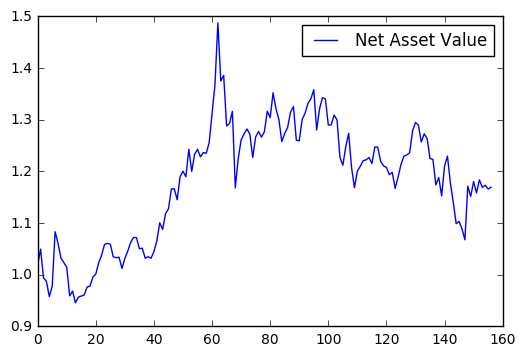

In [9]:
# simple_pa(pnl)
pmfc = (cagr(pnl), vol(pnl), sharpe_ratio(pnl), max_drawdown(pnl), drawdown_length(pnl))
print('CAGR:%f \nVolatility:%f\nSharpe_ratio:%f\nMax drawdown: %f\nDrawdown length: %d\n' % pmfc)

nowstr = datetime.now().strftime('%Y%m%d_%H:%M:%S')
pnl['cumpnl'] = np.cumsum(pnl['pnl'])
plot_nav(pnl)

pnl.to_csv('./output/pnl_series_' + nowstr + '.csv', index=False)
fr_hist.to_csv('./output/fitted_factor_return_' + nowstr + '.csv', index=False)
# plot_nav(pnl, savedir = './output/')

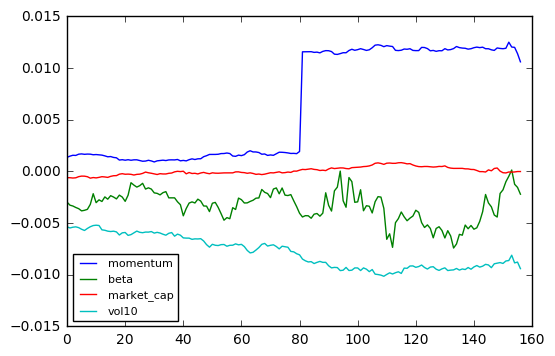

In [8]:
factor_names = fr_hist.columns[1:]
for name in factor_names:
    plt.plot(fr_hist[name])
    plt.legend(loc=3, prop={'size':8})
plt.show()